In [2]:
import astroquery
import matplotlib.pyplot as plt
import h5py
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import scipy

In [3]:
# Replace 'your_file.hdf5' with the path to your HDF5 file
file_path = 'data/DES_psf_y3_catalog.h5'

try:
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as file:
        # Print the keys at the root level of the file
        print("Root keys:")
        for key in file.keys():
            print(key)

        # You can navigate through the groups and datasets within the file
        # For example, if there is a group called 'group_name' within the file:
        if 'stars' in file:
            group = file['stars']
            print("\nGroup 'stars' keys:")
            for key in group.keys():
                print(key)

            # Access and print the content of a dataset within the group (if it exists)
            dset_name = 'calib_psf_reserved'
            
            if dset_name in group:
                dataset = group[dset_name]
                print(f"\nDataset {dset_name} shape:", dataset.shape)
                print(f"Dataset {dset_name} data:")
                print(dataset[:])  # Print the data

except FileNotFoundError:
    print(f"The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Root keys:
stars

Group 'stars' keys:
calib_psf_reserved
calib_psf_used
ccd
ccd_x
ccd_y
dec
extendedness
fov_x
fov_y
mag
measured_T
measured_e1
measured_e2
model_T
model_e1
model_e2
ra

Dataset calib_psf_reserved shape: (26539301,)
Dataset calib_psf_reserved data:
[1 1 1 ... 1 1 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


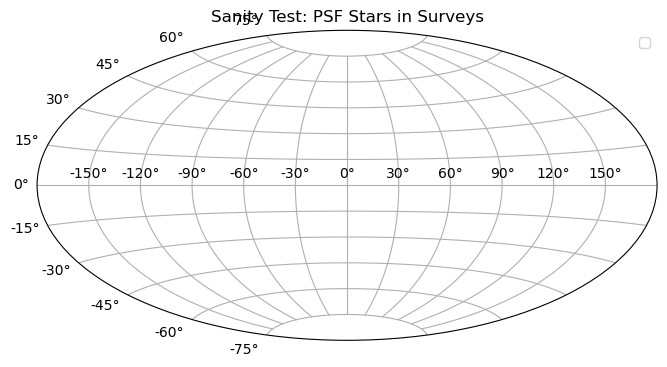

In [4]:
def plot_survey(path, name, n = 1000):

    with h5py.File(path, 'r') as file:
        era = file['/stars/ra']
        edec = file['/stars/dec']

        idxs = np.arange(1, len(era), 11)
        np.random.shuffle(idxs)
        idxs = np.sort(idxs[:n])

        ra = era[idxs] * u.degree
        dec = edec[idxs] * u.degree
        c = SkyCoord(ra=ra, dec=dec, frame='icrs')

        del era
        del edec

        ra_rad = c.ra.wrap_at(180 * u.deg).radian
        dec_rad = c.dec.radian

        plt.scatter(ra_rad, dec_rad, s=0.1, alpha=0.8, label = name)
        
        
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Sanity Test: PSF Stars in Surveys")
plt.grid(True)

hsc_path = 'data/star_catalog_hscy1_allfields.h5'
kids_path = 'data/kids1000_psf_catalog.h5'
des_path = 'data/DES_psf_catalog.hdf5'
desy3_path = 'data/DES_psf_y3_catalog.h5'

n = 10000

# plot_survey(desy3_path, "DES Y3", n)
# plot_survey(des_path, "DES Y1", n)
# plot_survey(kids_path, "KiDS", n)
# plot_survey(hsc_path, "HSC Y1", n)
    
plt.legend()

In [5]:
import matplotlib.pyplot as plt
import h5py
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import scipy

In [6]:
def wrap_ra(angles):
    wrapped = (angles > 180)
    angles[wrapped] = angles[wrapped] - 360
    return angles


def plot_survey_lim(path, name, s = 1):

    with h5py.File(path, 'r') as file:
        era = np.array(file['/stars/ra'])
        
        era = wrap_ra(era)
        
        edec = np.array(file['/stars/dec'])

        idxs = np.where((era < -25) & (era > -27) & (edec > -0.5) & (edec < 2))[0]
        
        print(idxs)
        
        ra = era[idxs]
        dec = edec[idxs]


        plt.scatter(ra, dec, s = s, label = name)

In [7]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the center coordinates of your region and the search radius
center_coordinates = SkyCoord(ra=-26.2, dec=0.03, unit=(u.degree, u.degree))
search_radius = 1.0 * u.arcsec  # Adjust the radius as needed
max_no = 100

# Query GAIA DR2 catalog for stars within the specified region
# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE 1 = CONTAINS(
#    POINT({center_coordinates.ra.degree}, {center_coordinates.dec.degree}),
#    CIRCLE(ra, dec, {search_radius.value}))
# """

# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE DISTANCE({center_coordinates.ra.degree}, {center_coordinates.dec.degree}, ra, dec) < {search_radius.value}
# """

query = f"""
SELECT *, DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) AS ang_sep
FROM gaiadr3.gaia_source
WHERE DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) < 60./60.
ORDER BY ang_sep ASC
"""

# AND phot_g_mean_mag < 21

# AND (phot_g_mean_mag BETWEEN 15.0 AND 21.0)
# AND (astrometric_excess_noise < power(10,0.15*(phot_g_mean_mag-15)+0.25))
# AND (phot_bp_rp_excess_factor > power(bp_rp, 2)*0.015+1.0)
# AND (phot_bp_rp_excess_factor < power(bp_rp, 2)*0.06+1.3)

job = Gaia.launch_job(query)
result_table = job.get_results()
gaia_table = result_table.to_pandas()
gaia_table["ra"] = gaia_table["ra"] - 360
# Print the result table (contains information about the stars)
print(result_table)

    solution_id             DESIGNATION          ...       ang_sep       
                                                 ...                     
------------------- ---------------------------- ... --------------------
1636148068921376768 Gaia DR3 2678742687012348032 ... 0.011538848329783948
1636148068921376768 Gaia DR3 2678742446493889408 ...  0.01366075597697389
1636148068921376768 Gaia DR3 2678742755731831808 ... 0.017592186627510453
1636148068921376768 Gaia DR3 2678742790091301760 ...  0.01791340848899132
1636148068921376768 Gaia DR3 2678742377774412544 ...  0.01833717012960006
1636148068921376768 Gaia DR3 2678742416429147904 ... 0.020166958549277983
1636148068921376768 Gaia DR3 2678742377774683008 ...  0.02098952699258283
1636148068921376768 Gaia DR3 2678742721371819136 ...  0.02142296082835619
1636148068921376768 Gaia DR3 2678742377774405376 ...  0.02396218509826504
1636148068921376768 Gaia DR3 2678742824451309696 ... 0.026683399993110778
                ...                   

In [8]:
gaia_table[["ra","dec"]]

,ra,dec
0,-26.207270,0.038960
1,-26.200052,0.016339
2,-26.205697,0.046644
3,-26.194920,0.047178
4,-26.188327,0.015858
...,...,...
1995,-26.108585,-0.296710
1996,-26.487159,-0.150677
1997,-26.089133,0.350687
1998,-25.931197,-0.177290


[  793357   793358   793359 ... 13396443 13396444 13396445]
[  567419   567420   567421 ... 12143174 12143175 12143176]
[600807 600813 600814 ... 731690 731691 731692]


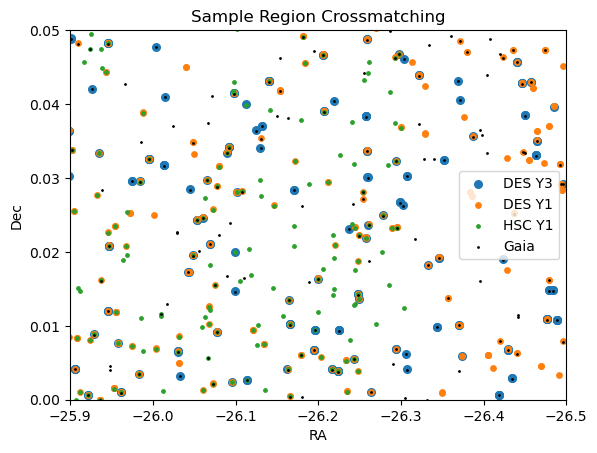

In [9]:
#plot_survey_lim(kids_path, "KiDS", s = 10)
plot_survey_lim(desy3_path, "DES Y3", s = 30)
plot_survey_lim(des_path, "DES Y1", s = 15)
plot_survey_lim(hsc_path, "HSC Y1", s = 6)
plt.scatter(gaia_table["ra"], gaia_table["dec"], s = 1, color = "k", label = "Gaia")

plt.xlim(-25.9, -26.5)
plt.ylim(0, 0.05)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("Sample Region Crossmatching")
plt.legend()
plt.savefig("crossmatch.png", dpi = 300)

In [10]:
with h5py.File(des_path, 'r') as file:
    era = file['/stars/ra']
    edec = file['/stars/dec']
    print(np.array(era).max())
    print(np.array(era).min())
    print(np.array(edec).max())
    print(np.array(edec).min())

100.87338256835938
-61.98074722290039
3.810236692428589
-68.33634185791016


In [11]:
from scipy.cluster.vq import vq, kmeans
 
# importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import scipy

from astroquery.gaia import Gaia
import astropy.units as u

In [12]:
def get_radec(path, s = 1):

    with h5py.File(path, 'r') as file:
        era = np.array(file['/stars/ra'])
        era = wrap_ra(era)
        
        edec = np.array(file['/stars/dec'])
        
        #idxs = np.where((era < -25) & (era > -27) & (edec > -0.5) & (edec < 2))[0]
        #print(idxs)
        
        ra = era#[idxs]
        dec = edec#[idxs]
        

        return ra, dec

In [14]:
def wrap_ra(angles):
    wrapped = (angles > 180)
    angles[wrapped] = angles[wrapped] - 360
    return angles
fobs = np.array(get_radec("data/DES_psf_catalog.hdf5", ))

In [15]:
obs = fobs[:, :100000]

In [62]:
obs.T.shape

(100000, 2)

In [26]:
number_of_clusters = 35
cents = kmeans(obs.T, number_of_clusters, )

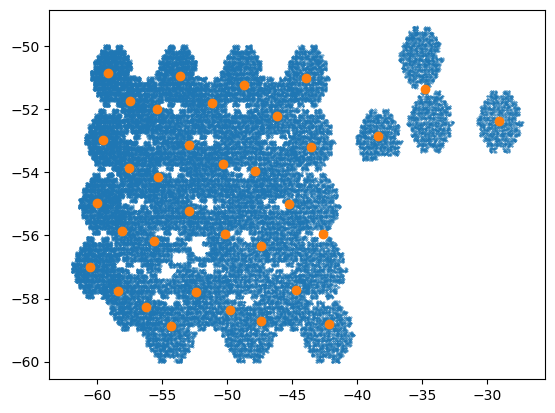

In [27]:
plt.scatter(obs[0], obs[1], s = 0.1)
plt.scatter(*cents[0].T)


In [28]:
centroids = cents[0]

In [29]:
cluster_num = vq(obs.T, centroids)

In [30]:
cluster_num

(array([ 9,  9,  9, ..., 19, 19, 19], dtype=int32),
 array([0.32849566, 0.31678954, 0.32395934, ..., 0.69454803, 0.68997702,
        0.73492184]))

In [31]:
max_dist_pts = {i:[np.array([k for k in cluster_num[1][cluster_num[0] == i]]).max()] for i in range(number_of_clusters)}
cluster_info = pd.DataFrame(max_dist_pts).T
cluster_info.columns = ["max_dist"]
cluster_info["clusterno"] = cluster_info.index
cluster_info["dists"] = [cluster_num[1][cluster_num[0] == i] for i in cluster_info["clusterno"]]
cluster_info["centroids"] = list(centroids)

In [32]:
cluster_info

,max_dist,clusterno,dists,centroids
0,1.415379,0,"[0.46442790589995975, 0.4692295337087506, 0.49...","[-55.31050192259712, -54.13666342852126]"
1,1.627390,1,"[0.8153625295484912, 0.8301272454906942, 0.808...","[-47.3804824621842, -56.31832716713568]"
2,1.587608,2,"[1.4924995535581733, 1.5146104141267958, 1.587...","[-46.19433340349768, -52.2065109370305]"
3,1.852881,3,"[1.5332565603771242, 1.5104001057669216, 1.438...","[-49.74577312699788, -58.36704257221131]"
4,1.905122,4,"[1.4171319220839362, 1.4543230711999877, 1.468...","[-44.73645910557369, -57.74321968851917]"
5,1.441099,5,"[0.9759480492116778, 0.9300382056161502, 0.880...","[-60.511537475857445, -56.998144107696426]"
6,1.396657,6,"[1.055337277149647, 1.058377333587277, 1.06198...","[-59.54682704099077, -52.959976235699486]"
7,1.656038,7,"[1.3484514514576444, 1.3628652084592543, 1.347...","[-51.14933786843894, -51.81149566380115]"
8,1.492588,8,"[0.8913715801314162, 0.8856588416782507, 0.954...","[-59.1615165146723, -50.85465061927775]"
9,2.432991,9,"[0.3284956605586174, 0.3167895407570023, 0.323...","[-34.7894572997249, -51.34791245703604]"


Text(0, 0.5, 'Dec')

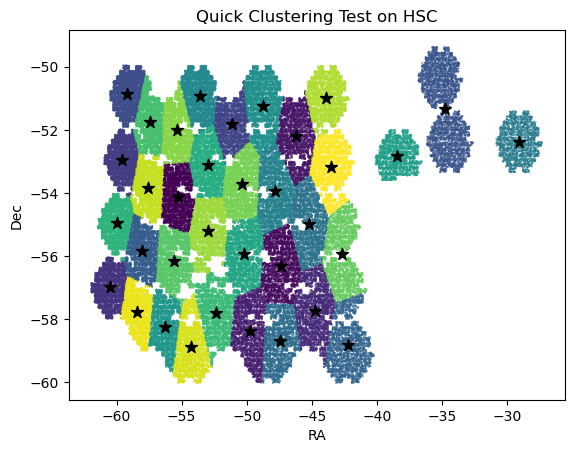

In [33]:
# scatter plot of K-Means cluster
plt.scatter(obs[0],
               obs[1],
               c=cluster_num[0], s  = 0.1)
 
# Centroid of the clusters
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            marker='*',
            s=80,
            color='black')

plt.title("Quick Clustering Test on HSC")
plt.xlabel("RA")
plt.ylabel("Dec")

In [34]:
def query_gaia_for_cluster(ra, dec, dist):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Gaia.ROW_LIMIT = -1
    job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    gaia_table["ra"] = wrap_ra(gaia_table["ra"])
    
    return gaia_table

In [35]:
cluster_info

,max_dist,clusterno,dists,centroids
0,1.415379,0,"[0.46442790589995975, 0.4692295337087506, 0.49...","[-55.31050192259712, -54.13666342852126]"
1,1.627390,1,"[0.8153625295484912, 0.8301272454906942, 0.808...","[-47.3804824621842, -56.31832716713568]"
2,1.587608,2,"[1.4924995535581733, 1.5146104141267958, 1.587...","[-46.19433340349768, -52.2065109370305]"
3,1.852881,3,"[1.5332565603771242, 1.5104001057669216, 1.438...","[-49.74577312699788, -58.36704257221131]"
4,1.905122,4,"[1.4171319220839362, 1.4543230711999877, 1.468...","[-44.73645910557369, -57.74321968851917]"
5,1.441099,5,"[0.9759480492116778, 0.9300382056161502, 0.880...","[-60.511537475857445, -56.998144107696426]"
6,1.396657,6,"[1.055337277149647, 1.058377333587277, 1.06198...","[-59.54682704099077, -52.959976235699486]"
7,1.656038,7,"[1.3484514514576444, 1.3628652084592543, 1.347...","[-51.14933786843894, -51.81149566380115]"
8,1.492588,8,"[0.8913715801314162, 0.8856588416782507, 0.954...","[-59.1615165146723, -50.85465061927775]"
9,2.432991,9,"[0.3284956605586174, 0.3167895407570023, 0.323...","[-34.7894572997249, -51.34791245703604]"


In [36]:
cluster_info.loc[0]

max_dist                                              1.415379
clusterno                                                    0
dists        [0.46442790589995975, 0.4692295337087506, 0.49...
centroids             [-55.31050192259712, -54.13666342852126]
Name: 0, dtype: object

In [37]:
clust = cluster_info.loc[0]
clust_tab = query_gaia_for_cluster(clust["centroids"][0], clust["centroids"][1], clust["max_dist"])

INFO: Query finished. [astroquery.utils.tap.core]


In [38]:
cluster0 = SkyCoord(obs.T[cluster_num[0] == 0] * u.deg)

In [39]:
cluster0

<SkyCoord (ICRS): (ra, dec) in deg
    [(305.15169144, -54.09115982), (305.15827179, -54.157341  ),
     (305.17670822, -54.05799103), ..., (305.66307831, -53.89919281),
     (305.76985168, -53.8481636 ), (305.74580383, -53.87123489)]>

In [51]:
(clust_tab['ra']) * u.deg

0       -55.308708
1       -55.319152
2       -55.307135
3       -55.323306
4       -55.291726
           ...    
86894   -55.202526
86895   -52.910639
86896   -54.162694
86897   -53.563524
86898   -52.935138
Name: ra, Length: 86899, dtype: float64

In [52]:
gaia0 = SkyCoord(ra = clust_tab['ra'], 
                        dec = clust_tab['dec'], unit=u.deg)

In [53]:
gaia0

<SkyCoord (ICRS): (ra, dec) in deg
    [(304.69129167, -54.1397727 ), (304.6808485 , -54.13708915),
     (304.692865  , -54.1313625 ), ..., (305.83730563, -52.89664843),
     (306.43647572, -53.17150308), (307.064862  , -54.41973299)]>

In [54]:
idx_gaia, sep2d_gaia, _ = gaia0.match_to_catalog_sky(cluster0)

Text(0.5, 1.0, 'Matched Stars: Separation in Arcsec')

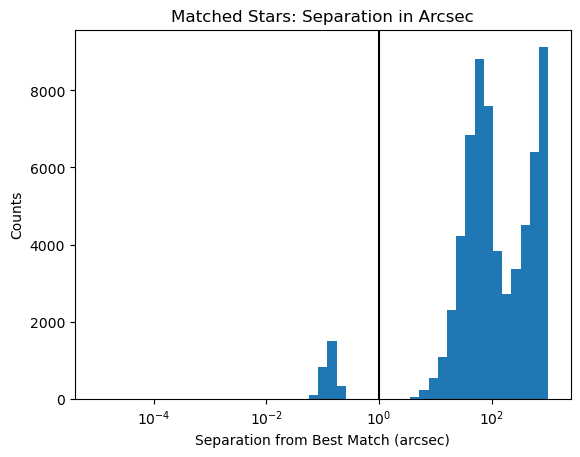

In [55]:
plt.hist(sep2d_gaia.arcsec, bins = np.logspace(-5, 3))
plt.semilogx()
plt.axvline(1, color = "k")
plt.ylabel("Counts")
plt.xlabel("Separation from Best Match (arcsec)")
plt.title("Matched Stars: Separation in Arcsec")

In [56]:
gaia_stars = gaia0[sep2d_gaia < 1 * u.arcsec]

In [57]:
hsc_stars = cluster0[idx_gaia][sep2d_gaia < 1 * u.arcsec]

Text(0.5, 1.0, 'Pre-Matching, Sample Region')

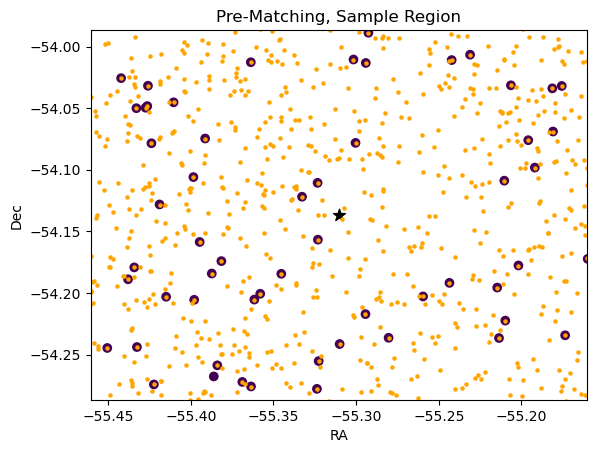

In [64]:
# scatter plot of K-Means cluster
plt.scatter(obs[0],
               obs[1],
               c=cluster_num[0])
 
# Centroid of the clusters
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            marker='*',
            s=80,
            color='black')

plt.xlabel("RA")
plt.ylabel("Dec")
plt.xlim(centroids[0][0] - 0.15, centroids[0][0] + 0.15)
plt.ylim(centroids[0][1] - 0.15, centroids[0][1] + 0.15)
plt.scatter(*np.array(clust_tab[["ra", "dec"]].T), color = "orange", s = 5)

plt.title("Pre-Matching, Sample Region")

In [ ]:
hsc_final = hsc_stars.to_table().to_pandas()
gaia_final = gaia_stars.to_table().to_pandas()

Text(0.5, 1.0, 'Post-Matching, Sample Region')

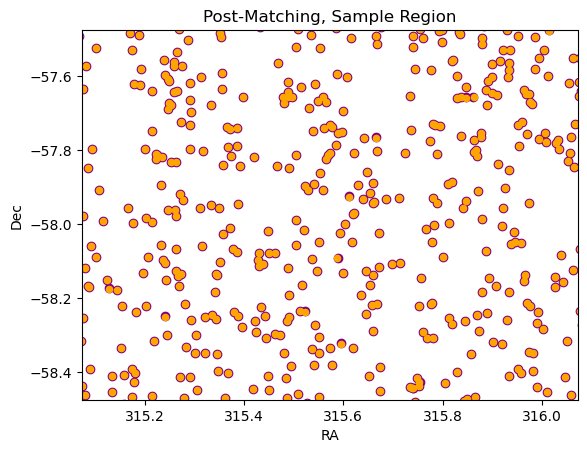

In [ ]:
plt.scatter(hsc_final["ra"], hsc_final["dec"], color = "purple")
plt.scatter(gaia_final["ra"], gaia_final["dec"], s = 20, color = "orange")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.xlim(centroids[0][0] + 360 - 0.5, centroids[0][0] + 360+ 0.5)
plt.ylim(centroids[0][1] - 0.5, centroids[0][1] + 0.5)
plt.title("Post-Matching, Sample Region")

In [ ]:
hsc_final.to_table().to_pandas()

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the center coordinates of your region and the search radius
center_coordinates = SkyCoord(ra=centroids[0][0], dec=centroids[0][1], unit=(u.degree, u.degree))
search_radius = 1.0 * u.arcsec  # Adjust the radius as needed
max_no = 100

# Query GAIA DR2 catalog for stars within the specified region
# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE 1 = CONTAINS(
#    POINT({center_coordinates.ra.degree}, {center_coordinates.dec.degree}),
#    CIRCLE(ra, dec, {search_radius.value}))
# """

# query = f"""
# SELECT source_id, ra, dec, phot_g_mean_mag
# FROM gaiadr3.gaia_source
# WHERE DISTANCE({center_coordinates.ra.degree}, {center_coordinates.dec.degree}, ra, dec) < {search_radius.value}
# """

# query = f"""
# SELECT ra, dec, DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) AS ang_sep
# FROM gaiadr3.gaia_source
# WHERE DISTANCE({center_coordinates.ra.deg}, {center_coordinates.dec.deg}, ra, dec) <  300./60.
# ORDER BY ang_sep ASC
# """

# AND phot_g_mean_mag < 21

# AND (phot_g_mean_mag BETWEEN 15.0 AND 21.0)
# AND (astrometric_excess_noise < power(10,0.15*(phot_g_mean_mag-15)+0.25))
# AND (phot_bp_rp_excess_factor > power(bp_rp, 2)*0.015+1.0)
# AND (phot_bp_rp_excess_factor < power(bp_rp, 2)*0.06+1.3)
Gaia.ROW_LIMIT = -1
job = Gaia.cone_search_async(center_coordinates, radius=u.Quantity(3.0, u.deg), columns=["ra", "dec"])
# job = Gaia.launch_job(query)
result_table = job.get_results()
gaia_table = result_table.to_pandas()
gaia_table["ra"] = wrap_ra(gaia_table["ra"])
# Print the result table (contains information about the stars)
print(result_table)